# Feature Map Clustering Pt.1

A generative neural network learns a set of parameters to approximately model a target distribution. However, understanding the rules encoded in the intermediate layers is always an obscure problem. This project attempts to cluster the feature maps in the intermediate layers to create groups, then apply [Network Bending](https://arxiv.org/abs/2005.12420) operations on these groups. Based on the assumption that spatially similar features contribute to specific semantic properties of the generated images [[3]](), operations on grouped layers might create more interpretable outcomes. Ideally, it might create a set of directions to manipulate the network.

## Run the Clustering Algorithm

In [1]:
import pickle

from sklearn.preprocessing import StandardScaler

In [2]:
features_std = []

for i in range(8):
    shape = 2**int((i+4)/2)
    feature = pickle.load( open( f'./feature_maps/features_{shape}x{shape}_{i}.p', "rb" ) )
    
    feature_rs = feature.reshape((512,shape*shape))

    scaler = StandardScaler()
    feature_std = scaler.fit_transform(feature_rs).reshape(512,shape,shape)
    
    
    features_std.append(feature_std)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def show_grid(images,shape=(12,12),figsize=(14,14)):
    fig, axs = plt.subplots(shape[0],shape[1], figsize=figsize)
    x = shape[0]
    y = shape[1]
    for i,img in enumerate(images[:x*y]):
        axs[int(i/x),i%x].axis('off')
        axs[int(i/x),i%x].title.set_text(f'index {i:03}')
        axs[int(i/x),i%x].imshow(img,cmap='Greys')

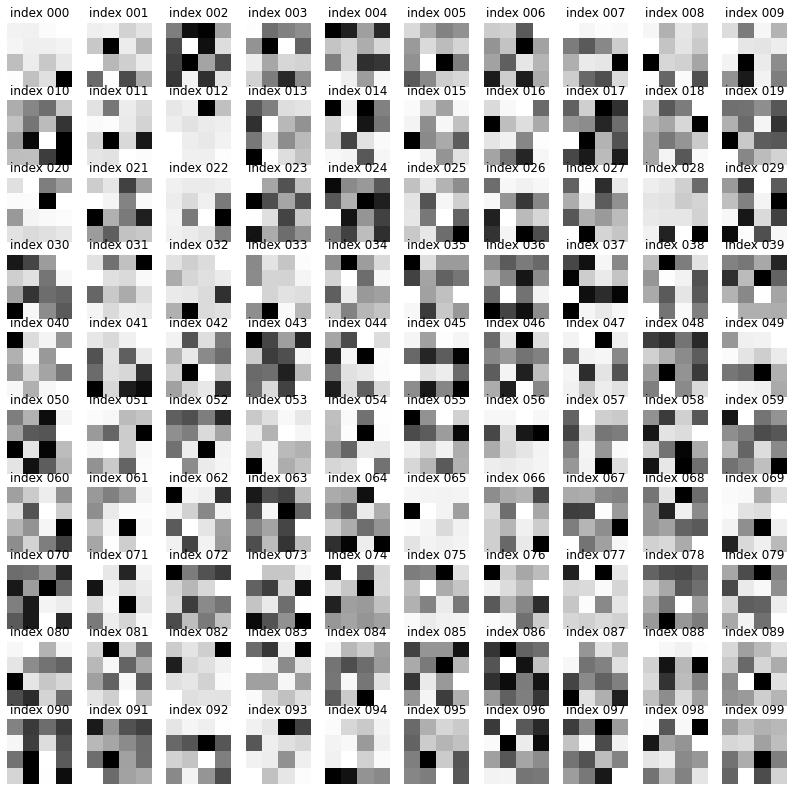

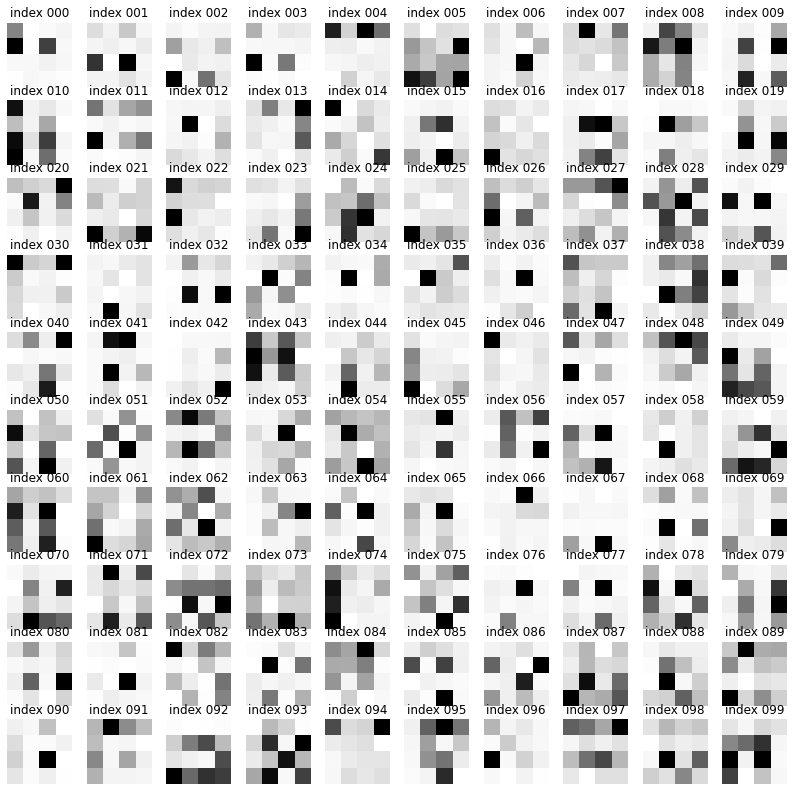

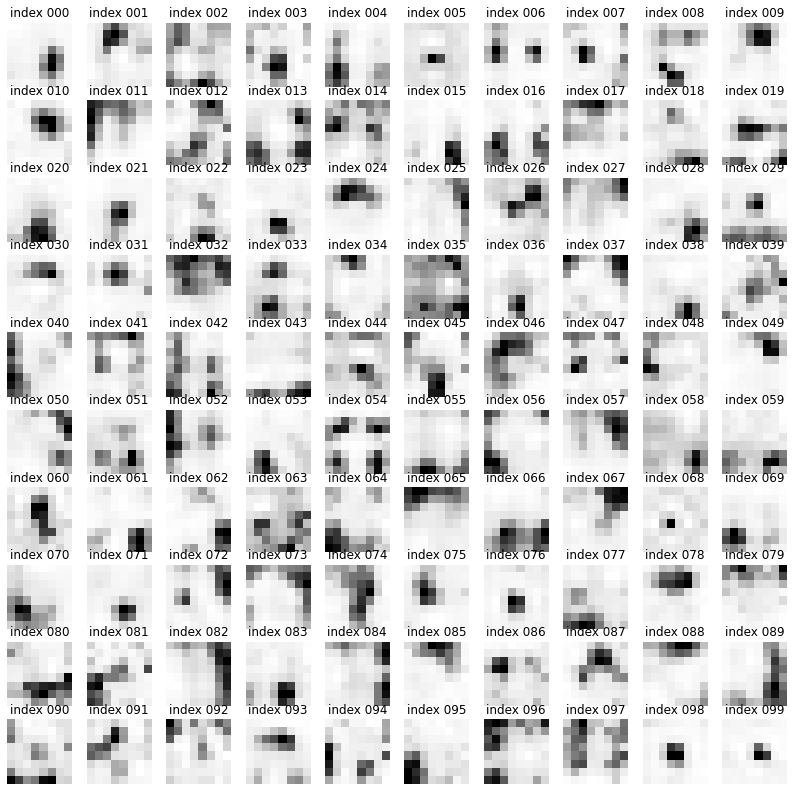

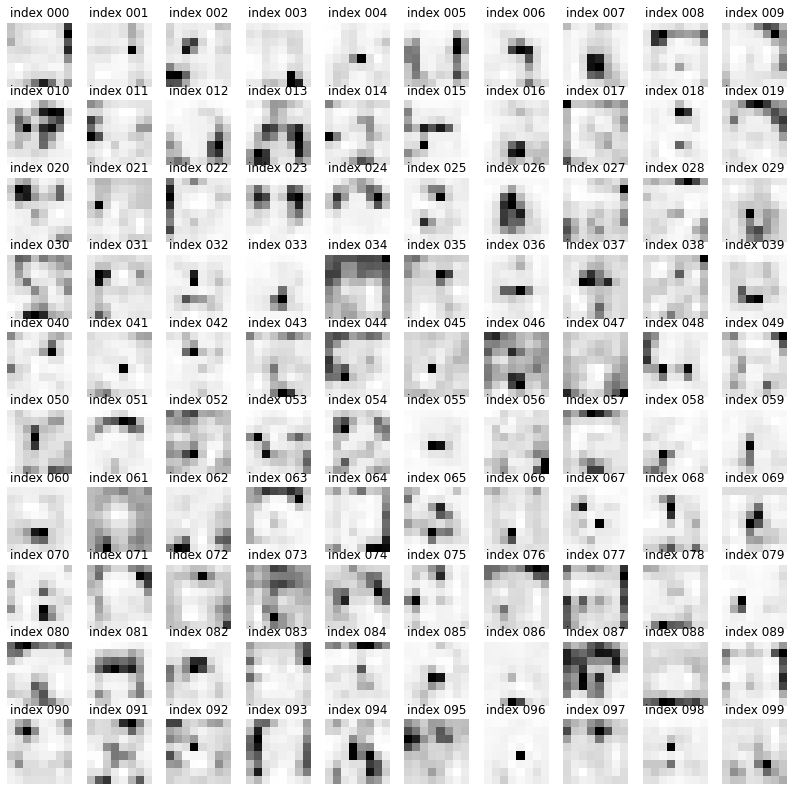

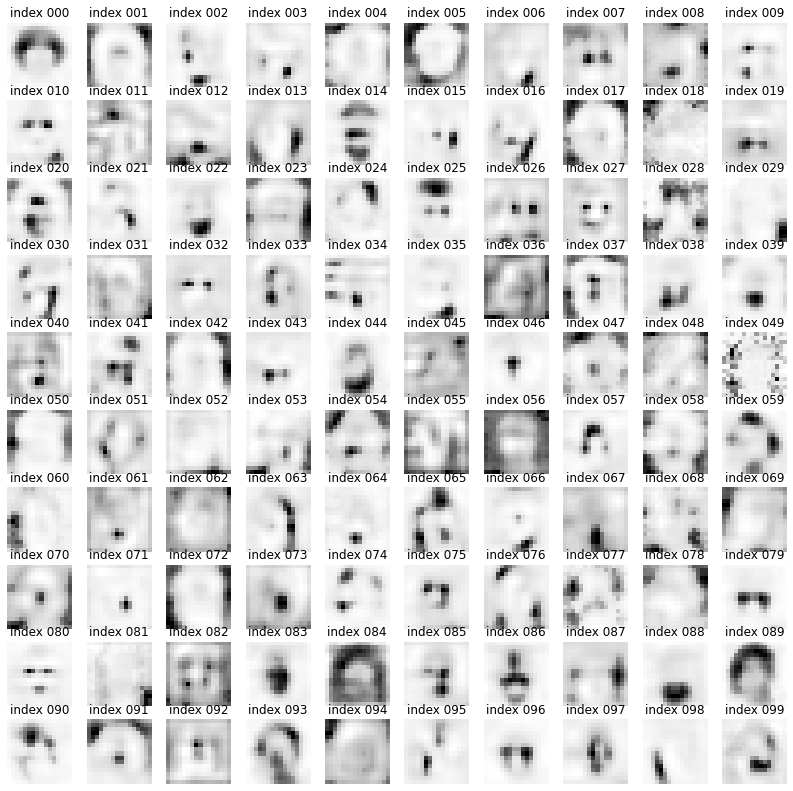

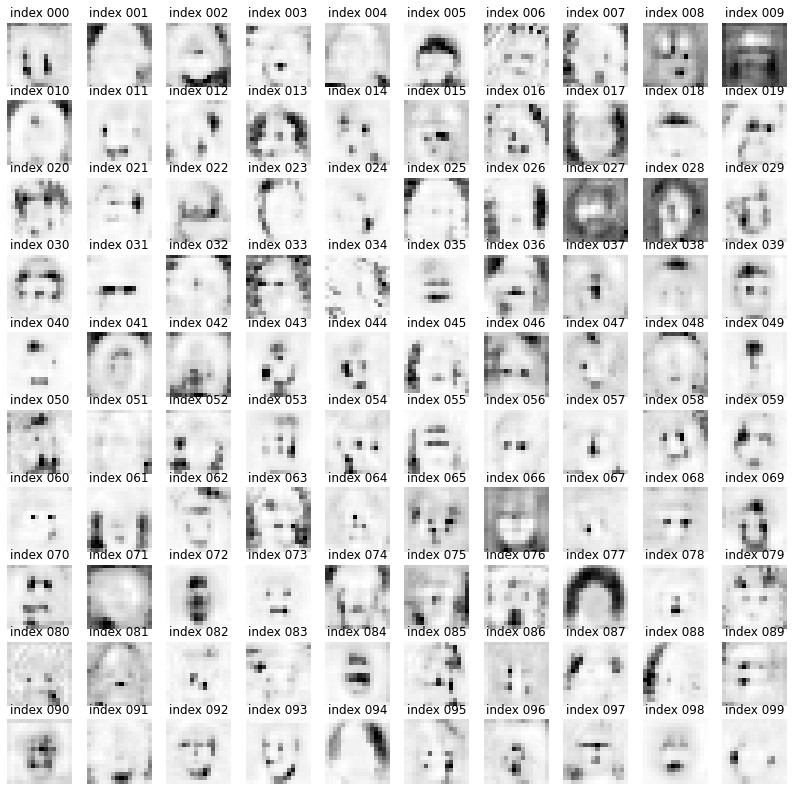

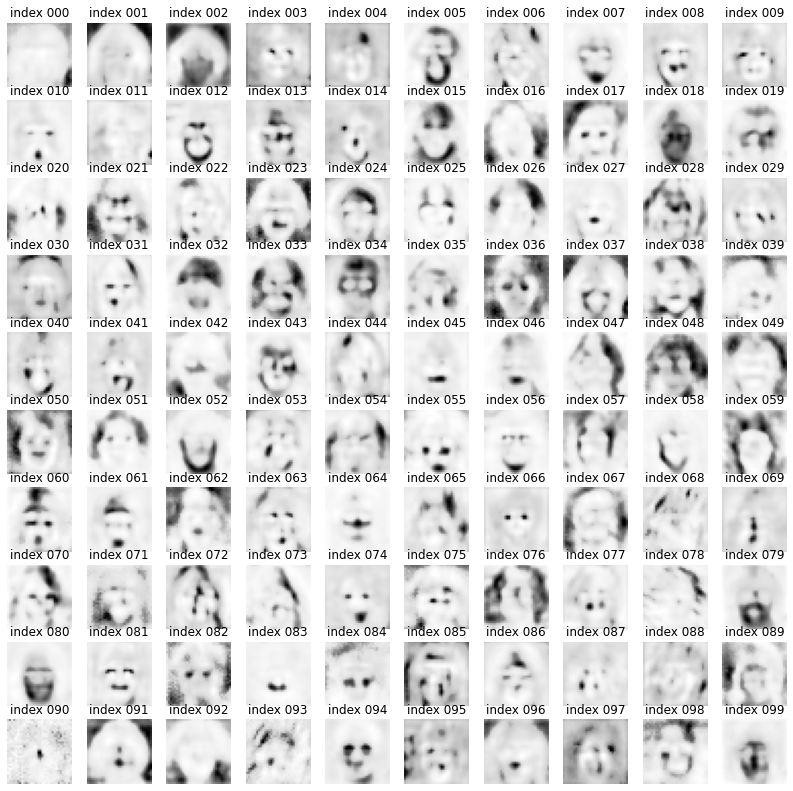

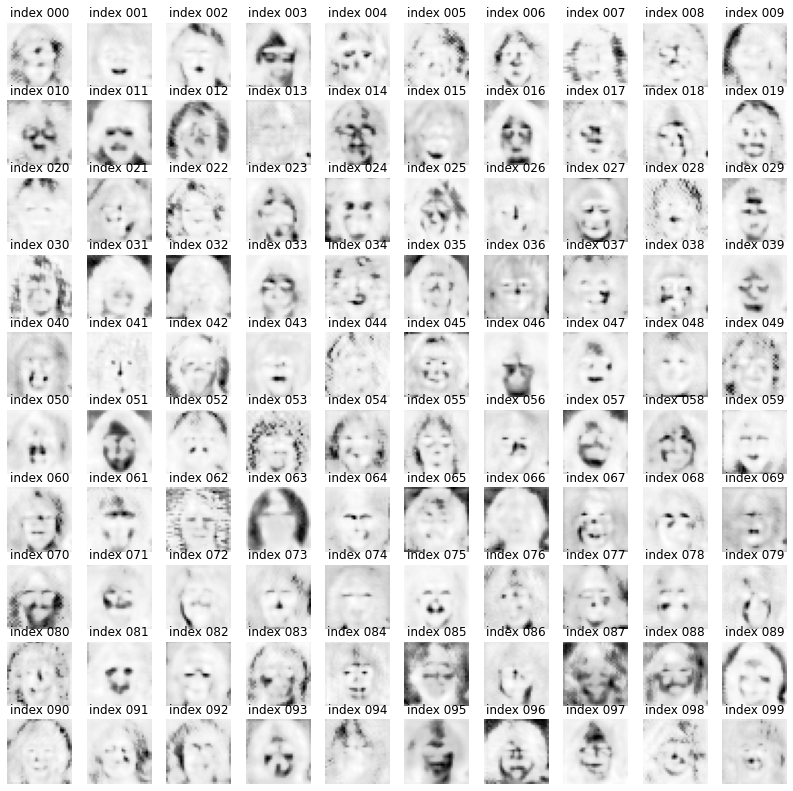

In [4]:
for i in range(8):
    show_grid(features_std[i][:100],shape=(10,10))   

In [5]:

from tensorflow.keras.applications.vgg16 import preprocess_input 

from PIL import Image

from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.models import Model

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation,SpectralClustering,DBSCAN

def show_clusters(n,labels,features,start=0,cluster_n=2):
    
    fig = plt.figure(constrained_layout=True,figsize=(10,cluster_n*10))
    subfigs = fig.subfigures(n,1)
    
    for i in range(n):
        index = i+start
        cluster = []
        for i_feature,l in enumerate(labels):
            if l==index:
                cluster.append(features[i_feature])
        
        axs_s = subfigs[i].subplots(cluster_n,10)
        subfigs[i].suptitle(f'cluster {index:03}')
        
        for x in range(cluster_n*10):
            axs_s[x%cluster_n,int(x/cluster_n)].axis('off')
            
            if x < len(cluster):
                axs_s[x%cluster_n,int(x/cluster_n)].imshow(cluster[x],cmap='Greys')


In [ ]:
#%%


for n in range(2):
    size = 2**int((n+4)/2)
    
    if n<2:
        print(f'Pixel clustering {n}')
        features_pixel = features_std[n].reshape(512,size*size)
        kmeans_pixel = DBSCAN(eps=3, min_samples=4).fit(features_pixel)
        
        labels_pix = kmeans_pixel.labels_
        centers = kmeans_pixel.core_sample_indices_
        print(f'plotting {n}')
        print(len(centers))
        show_clusters(16,labels_pix,features_std[n],start=0,cluster_n=2)
        
        #pickle.dump( labels_pix, open( f"./clustered_maps/labels_{size}x{size}_{n}_affinityCluster_8.p", "wb" ) )
    else:
        print(f'VGG clustering {n}')
        
        model = VGG16()
        model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

        features_vgg = []
        for i,f in enumerate(features_std[n]):
            img = Image.fromarray(f)
            img_resize = img.resize((224,224)).convert('RGB')
            img_array = np.expand_dims(np.asarray(img_resize), 0)
            
            imgx = preprocess_input(img_array)
            pred = model.predict(imgx, use_multiprocessing=True)
            features_vgg.append(pred)
            if i%10==0:
                print(f'extracting {i:03}')
                
        features_vggs = np.array(features_vgg).reshape(-1,4096)
        pca = PCA(n_components=8, random_state=22)
        pca.fit(features_vggs)
        x = pca.transform(features_vggs)
        
        kmeans = KMeans(n_clusters=8,random_state=1)
        kmeans.fit(x)

        labels = kmeans.labels_

        print(f'plotting {n}')
        show_clusters(8,labels,features_std[n],start=0,cluster_n=2)
        
        pickle.dump( labels, open( f"./clustered_maps/labels_{size}x{size}_{n}_vggCluster_8.p", "wb" ) )
